In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts", "lib"))


import numpy as np
import pandas as pd
from cov_functions import *
from clustering_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
from scipy.stats import zscore as zscore_sc
import pingouin as pg

warnings.filterwarnings('ignore')
from tslearn.utils import to_time_series
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

import tslearn as tsl

mapdict = {#'TF3_NegativeAffect': 'TF3',
        #'TF2_PhysiolAnx': 'TF2', 
        #'TF1_CognAnxDepr': 'TF1',
        'stai_ta': "TA",
        'covid_worry': 'Worry', 
        'prob_est': 'Probest',
        'q7_worry_econ_impact': 'EconWorr',
        'q6_apply_soc_dist': 'SocialDist',
        'q6_risk_group': 'RiskGr',
        'avoid_beh': 'AvoidBeh',
        'avoid_anx': 'AvoidAnx',
        'q6_media_freq_num': 'InforSeek',
        'q6_media_valence': 'MediaVal',
        'q7_period_rel_danger': 'DangerSate',
        'deaths': 'Deaths',
        'cases': 'Cases',
        'worryhealth': 'HealthWorry',
        'q6_work_home': "WorkHome",
        'sticsa_som_sa_currsess': "StateSomAnx",
    #    "q6_close_person_infdied": "ClosePDied",
        "covid_thoughts": "CovThoughts", 
        "memory_worry_infected_baselined": "MemWorry", 
        "memory_prob_infected_baselined": "MemProb", 
        "sr_age": "Age", 
        "q6_me_inf": "WasInfected", 
        "q6_close_person_inf": "ClosePersonInfected", 
        "q6_close_person_died": "ClosePersonSevere",
        "q6_houshold_membs": "HouseholdMembers",
        "postcode_density": "PopulationDensity"

        #"affheallth-econ-worry": "Health>Econ \n worry", 
        #"covid_cases_est_diff": "Estimate of \n covid cases"
        }


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))

df["GROUP"] = df.GROUP.map({'UK':'UK', 'BE':'GER'}) 

df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

df=df.rename(columns=mapdict)
dfall = df.copy()

## filter for weird ages 
df.loc[(df["Age"]<18) | (df["Age"]>42), "Age"] = np.nan

#df = df.loc[:,vars+["PROLIFICID","session"]]
#tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)


#id_df = dfall.loc[:,["PROLIFICID","TF3", "TF2", "TF1", "TA"]].groupby(by=["PROLIFICID"]).mean()
#df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_1.csv"))

vars = ["DangerSate", "Probest" , "Worry", "AvoidBeh", "InforSeek" ]
vars_from_s1 = ["Age", "RiskGr","SocialDist", "WorkHome","Cases", "Deaths", "WorkHome", "stai_sa", "MediaVal"] 
vars_from_s20 =["WasInfected",  "ClosePersonInfected", "ClosePersonSevere", "SocialDist", "WorkHome","Cases", "Deaths", "WorkHome", "stai_sa", "MediaVal" ]
def zscore_sc_t(x, nan_policy='omit'):
    return zscore_sc(x, nan_policy=nan_policy)
#vars2zscore = ["TF1_CognAnxDepr", "TF2_PhysiolAnx","TF3_NegativeAffect", "HouseholdMembers", "Age", "RiskGr","SocialDist", "WorkHome","Cases", "Deaths", "WorkHome", "stai_sa", "MediaVal", "skepticism", "WasInfected",  "ClosePersonInfected", "ClosePersonSevere"]
vars2zscore = ["TF1_CognAnxDepr", "TF2_PhysiolAnx","TF3_NegativeAffect", "HouseholdMembers", "Age", "Cases", "Deaths", "WorkHome", "stai_sa", "MediaVal", "skepticism",  "RiskGr", "SocialDist", "PopulationDensity"]
# zscore all involved vars
df.loc[:,vars2zscore] = df.loc[:,vars2zscore].apply(zscore_sc_t, nan_policy='omit')

#df = df.set_index("PROLIFICID")
# session-specific vars
dfs1 = df.loc[df["session"]==1,vars_from_s1+["PROLIFICID"]].set_index("PROLIFICID")
dfs20 = df.loc[df["session"]==20,vars_from_s20+["PROLIFICID"]].set_index("PROLIFICID")
dfs1.columns = [x+"_s1" for x in dfs1.columns]
dfs20.columns = [x+"_s20" for x in dfs20.columns]


split_to_dummy_from_s1 = ["GROUP", 'sr_gender']
dfdm = df.loc[df["session"]==1,split_to_dummy_from_s1+["PROLIFICID"]].set_index("PROLIFICID")
dfdm = pd.get_dummies(dfdm["GROUP"]).join(pd.get_dummies(dfdm["sr_gender"]))
df = df.set_index("PROLIFICID").join(dfs1).join(dfs20).join(dfdm)


#vars that will be just averaged across sessions
iv_vars = ["TF1_CognAnxDepr", "TF2_PhysiolAnx","TF3_NegativeAffect", "HouseholdMembers", "PopulationDensity", "skepticism"] + list(dfdm.columns) + [x+"_s1" for x in vars_from_s1] + [x+"_s20" for x in vars_from_s20] 

### Meta parameters
corr_type = "spearman" # used in all analyses

no_trait_factors = 3
trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
tf_short = ["TF1", "TF2", "TF3"]

cluster_metric =  "euclidean"#"euclidean"#"dtw" # "euclidean"

df=df.reset_index()


/data/drive/postdoc/Project4_covid


/home/ondrej/anaconda3/envs/covid_pyenv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:

#df.GROUP.map({'UK':'UK', 'BE':'GER'})

### Estimation of clusters

In [3]:
run_cluster_size_estimation = False

if run_cluster_size_estimation:
    cldata = pd.DataFrame()
    #depvar = "F1_CovidAnxietyWorry"

    for depvar in vars:
        tdf = df.loc[:,[depvar]+["session", "PROLIFICID"]]
        tdf = tdf.pivot(index='PROLIFICID', columns='session', values=depvar).add_prefix('sess')

        # Vrey important, otherwise clustering doesn't work! 
        tdf = tdf.interpolate(method='linear', axis=1)

        # Turn to timeseries data type
        ts = tsl.utils.to_time_series(tdf)

        #tdf, m = estimate_clusters(ts, n_clusters=cl, metric="euclidean")
        #print("c="+str(cl) + " S="+ str(silhouette_score(ts,tdf.cl, metric="euclidean")))
        print(depvar)
        ssc =[]
        clsize = range(2,6)
        for nc in clsize:
            tdf, m = estimate_clusters(ts,tdf, n_clusters=nc, metric=cluster_metric)
            sc = silhouette_score(ts,tdf.cl, metric=cluster_metric)
            ssc.append(sc)
            print("c="+str(nc) + " S="+ str(sc))
        cldata = pd.concat([cldata, pd.DataFrame({'var':depvar, 'noclusters':[clsize[np.argmax(ssc)]]})], axis=0)
    cldata.to_csv(os.path.join(root_dir, "data", "number_of_cluster_data_"+cluster_metric+".csv"))
else:
    cldata = pd.read_csv(os.path.join(root_dir, "data", "number_of_cluster_data_"+cluster_metric+".csv"))

### Visualize clusters

In [4]:
import scipy.stats as sc
def visualize_clusters_ver2(df, tdf, model, dep_var, huevar, n_clusters=10):
    # df - overall data set 
    # tdf - data in wide format, output of estimate_clusters() 
    # model - estimated model
    # dep_var - which variable are we clustering
    # huevar - second variable to color clusters by
    
    # get information from the model
    ts = to_time_series(tdf.drop(columns=["cl", "id"]))
    #cl_ids = model.predict(ts)
    
    # rank clusters 
    cl = np.unique(tdf.cl)
    me = np.zeros(cl.shape[0])
    for c in np.unique(tdf.cl):
        me[c] = tdf.loc[tdf.cl==c,"sess1":"sess20"].mean().mean()
    rk = sc.rankdata(me).astype(int)-1
    tdf.cl = tdf.cl.map(dict(zip(cl, rk)))

    clusters = np.transpose(np.squeeze(model.cluster_centers_))
    new_clusters = np.zeros(clusters.shape)
    for o, n in zip(cl, rk):
        new_clusters[:,n] = clusters[:,o]

    (unique, counts) = np.unique(tdf.cl, return_counts=True)

    # where will labels be shown 
    lbl_x = 15
    y = new_clusters[lbl_x,:]
    me=tdf[["sess"+str(lbl_x), "cl"]].groupby("cl").mean()
    yme=np.array(me["sess"+str(lbl_x)]) +0.5
    
    # turn back to long format
    tdf2 = tdf.melt(id_vars=["id", "cl"], value_vars=["sess"+str(x) for x in range(1,21)]).set_index("id")

    
    # plot 
    f, ax = plt.subplots(1,1,figsize=(5,4))
    pal= ["crimson", "dodgerblue", "cornflowerblue",  "forestgreen","orange","darkcyan",  "black"]#sns.color_palette("rocket_r", 4)
    sns.lineplot(data=tdf2, x="session", y="value", hue="cl", palette=pal, legend=False, ax=ax)
    ax.set_xticklabels([str(i) for i in range(1,21)])
    ax.set_ylabel(dep_var) 
    ax.set_title(dep_var)
    tics = ax.get_yticks()
    
    ax.set_yticks(np.linspace(min(tics), max(tics), 2 , dtype=int) )

    #fig, ax = plt.subplots(1,len(huevar), figsize=(len(huevar)*4, 5))
    #for f_idx, hv in enumerate(huevar):

        # add anxiety to the dataset
    stdf = tdf2.join(df.loc[:,["PROLIFICID"]+huevar].groupby("PROLIFICID").mean())
        # Set your custom color palette
    #    pal=sns.color_palette("rocket_r", n_clusters)
        
        #get mean anxiety per bin
    anx_cluster = stdf.loc[:,["cl"]+huevar].groupby(["cl"]).mean()
    #    plt.ylabel(dep_var)
    for i,v,c,y in zip(np.array(anx_cluster.index),unique, counts,yme):
        ax.annotate("n="+str(c)+" cluster="+str(v), (lbl_x,y),   bbox=dict(boxstyle="round", fc="w", edgecolor=pal[i]))
    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', 'cluster_'+ dep_var+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')  
    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'paper_figures', 'clusters', 'cluster_'+ dep_var+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')  



    ### show second plot
    stdf = tdf.loc[:,["id", "cl"]].join(df.loc[:,["PROLIFICID"]+huevar].groupby("PROLIFICID").mean())
    stdf = stdf.melt(id_vars=["id", "cl"], value_vars=huevar).set_index("id")

    results = []
    for v in huevar:
        ttest_res = pg.ttest(stdf.loc[(stdf['cl'] == 0) & (stdf['variable'] == v) , "value"]  ,  stdf.loc[(stdf['cl'] == 1) & (stdf['variable'] == v) , "value"] , paired=False)
        results.append({
            'Variable': v,
            'df': ttest_res['dof'][0],
            'p-value': ttest_res['p-val'][0],
            't-score': ttest_res['T'][0]
        })
    stats_df = pd.DataFrame(results)

    f, ax = plt.subplots(1,1,figsize=(3,4+2*n_clusters) ) 
    axx=sns.barplot(data=stdf, hue="cl", x="value", y="variable", errorbar="se",ax=ax,  palette=pal)
    axx.set_xlabel("z-score") 
    axx.set_title(dep_var)
    axx.set_yticklabels(axx.get_yticklabels(), rotation = 0,fontsize=17) # ha='left', 

    # Adding asterisks for significant variables
    significance_threshold = 0.05  # Define your significance threshold
    y_ticks = axx.get_yticks()
    y_ticklabels = [item.get_text() for item in axx.get_yticklabels()]

    # Convert 0.1 inch to data units for x position adjustment
    fig = ax.get_figure()
    fig.canvas.draw()
    trans = ax.transData.inverted()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    inch_to_data = (0.1 / bbox.width) * (ax.get_xlim()[1] - ax.get_xlim()[0])

    for i, label in enumerate(y_ticklabels):
        p_value = stats_df.loc[stats_df['Variable'] == label, 'p-value'].values[0]
        if p_value < significance_threshold:
            bars = axx.patches[i::len(y_ticklabels)]
            leftmost_bar = max(b.get_width() for b in bars)
            mid_y = 0.2 + (bars[0].get_y() + bars[1].get_y() + bars[1].get_height()) / 2  # Middle y position between the two bars
            #ax.text(leftmost_bar + 0.6, mid_y, 'p='+str(round(p_value,4)), ha='center', va='center', color='black', fontsize=12)
            ax.text(leftmost_bar + 0.2, mid_y, '*', ha='center', va='center', color='black', fontsize=12)





    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'paper_figures', 'clusters', 'cluster_props_'+ dep_var+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')  
    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', 'cluster_props_'+ dep_var+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')  



In [5]:
np.sqrt(150)

12.24744871391589

DangerSate
Probest
Worry
AvoidBeh
InforSeek


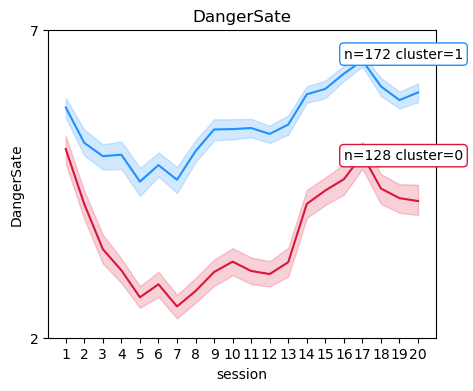

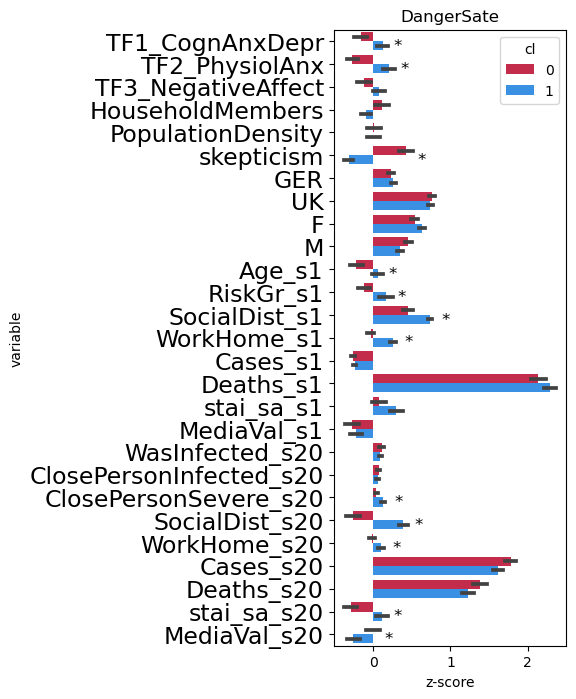

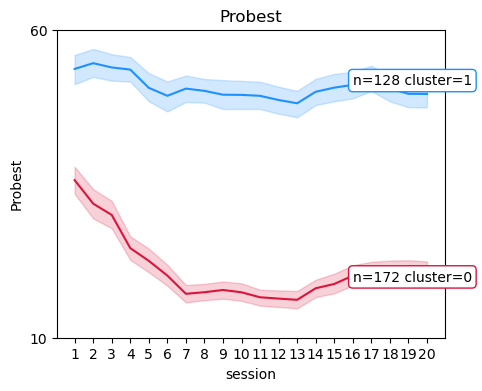

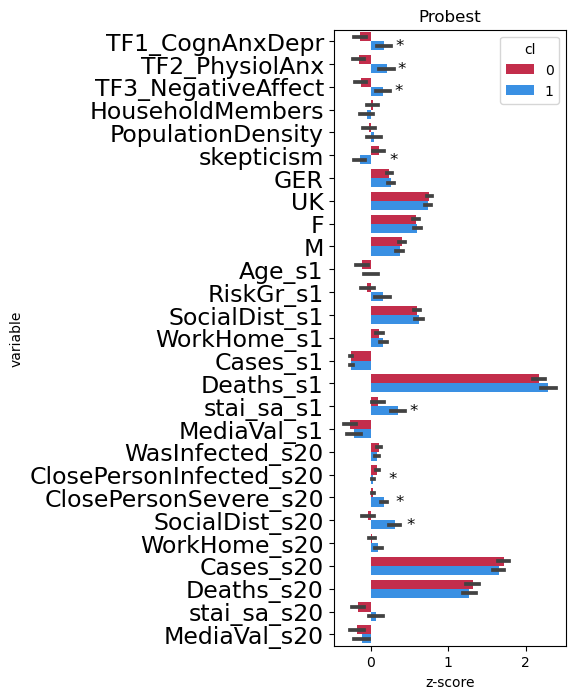

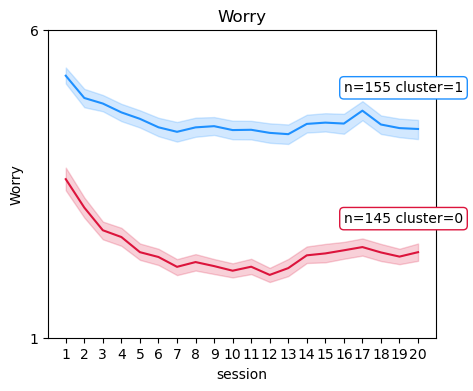

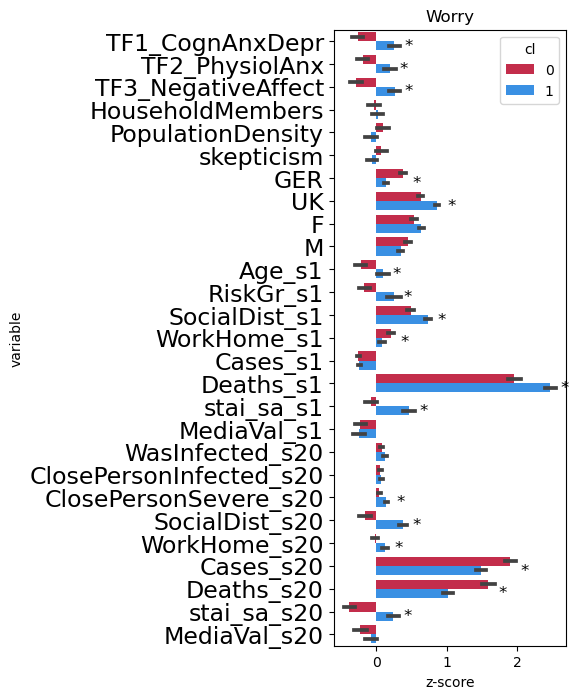

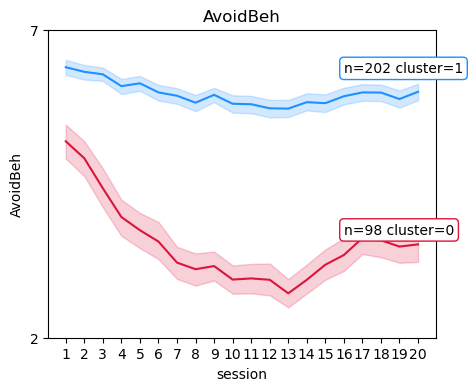

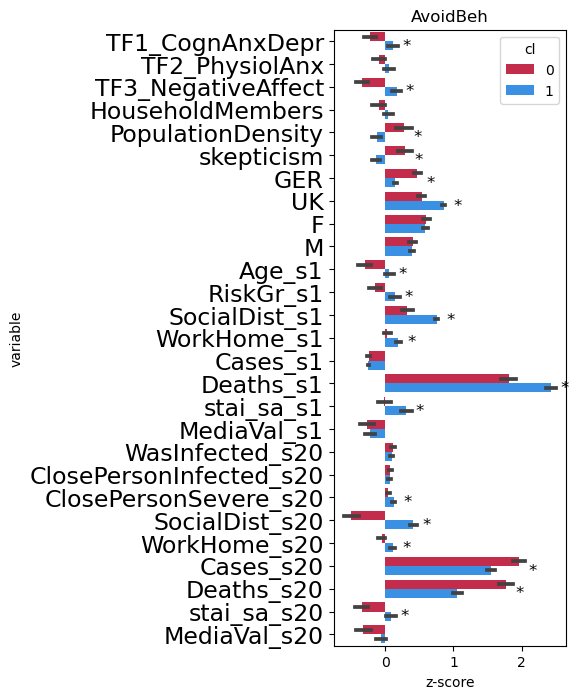

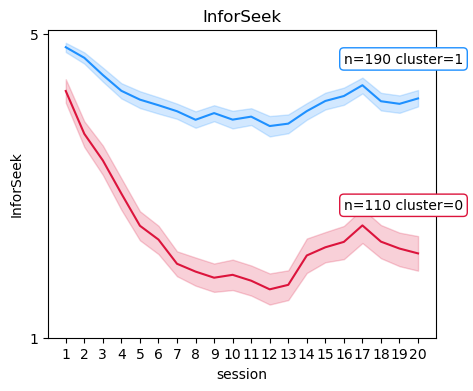

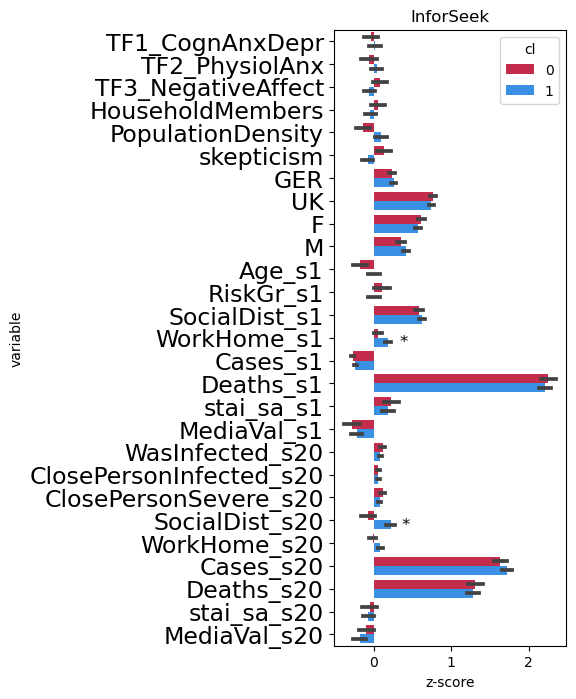

In [6]:
for depvar in vars:#[vars[0]]:
    print(depvar)
    tdf = df.loc[:,[depvar]+["session", "PROLIFICID"]]
    tdf = tdf.pivot(index='PROLIFICID', columns='session', values=depvar).add_prefix('sess')

    # Important, otherwise clustering doesn't work! 
    tdf = tdf.interpolate(method='linear', axis=1)

    # turn to timeseries data type
    ts = to_time_series(tdf)

    #tdf, m = estimate_clusters(ts,tdf, n_clusters=int(cldata.loc[cldata["var"]==depvar, "noclusters"]), metric=cluster_metric)
    tdf, m = estimate_clusters(ts,tdf, n_clusters=2, metric=cluster_metric)

    #visualize_clusters_ver2(df, tdf, m, depvar, iv_vars, n_clusters=int(cldata.loc[cldata["var"]==depvar, "noclusters"]))
    visualize_clusters_ver2(df, tdf, m, depvar, iv_vars, n_clusters=2)

    #tdf, m = estimate_clusters(ts,tdf, n_clusters=2, metric="euclidean")
    #visualize_clusters(df, tdf, m, depvar, trait_factor_names, n_clusters=2)